In [201]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import sbi
from scipy.stats import gaussian_kde
import torch

from CASBI.generator.fff.fff_model import FreeFormFlow


from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_custom_prior,
    process_simulator,
)

from sbi.neural_nets.embedding_nets import (
    FCEmbedding,
    CNNEmbedding,
    PermutationInvariantEmbedding
)

In [7]:
Flow = FreeFormFlow(dim = 2, 
                    cond_dim = 6,
                    hidden_dim = 128,
                    latent_dim = 2,
                    n_SC_layer = 6,
                    beta = 100**2,
                    device = 'cuda:2')

Flow.load_state_dict(torch.load('./snapshot/fff_snapshot/best_snapshot.pth'))

<All keys matched successfully>

## KDE_conditional_prior

In [33]:
class gen_halo_conditions(torch.distributions.Distribution):
    def __init__(self, conditions:pd.DataFrame, n_bins:int=100, n_halos:int=10, ):
        super().__init__()

        self.conditions = conditions
        self.masses = conditions['star_log10mass']
        self.bin_mass = (max(self.masses) - min(self.masses))/n_bins
        self.n_halos = n_halos
    
    def gen_conditions(self):
        """Generate sample conditions based on given conditions, taking into account correlations between conditions.

        Args:
            conditions (pandas.DataFrame): The conditions to generate sample conditions from.
            n_bins (int, optional): The number of bins to use for generating sample conditions. Defaults to 100.

        Returns:
            dict: The generated sample conditions.

        """
        sample_conditions = []
        for j in range(self.n_halos):
            kde = gaussian_kde(self.masses)
            star_mass = kde.resample(1)[0][0]
            sample_conditions.append(star_mass)
            
            cut_in_mass = self.conditions[(star_mass - self.bin_mass < self.masses) & (self.masses<star_mass + self.bin_mass)]
            conditions_to_sample = cut_in_mass.columns.difference(['star_log10mass', 'infall_time', 'Galaxy_name'], sort=False)
        
            for i, col in enumerate(conditions_to_sample):
                possible_cond = cut_in_mass[col].values
                kde = gaussian_kde(possible_cond)
                sample_conditions.append(kde.resample(1)[0][0])

            kde = gaussian_kde(self.conditions['infall_time'])
            infall_time = kde.resample(1)[0][0]
            sample_conditions.append(infall_time)
        
        return torch.tensor(sample_conditions, dtype=torch.float32)
    
    def sample(self, sample_shape=torch.Size([2]), ):
        """
        Generate conditions in a hierarchical way, with Gas Mass, dm mass, std and mean metallicity depend hierarchically from Star mass, 
        Infall time is independed from all the others.
        """
        genereated_halo_conditions = torch.zeros((sample_shape[0], self.n_halos*6))
        for n in range(sample_shape[0]):
            sample_conditions = self.gen_conditions()
            genereated_halo_conditions[n] = sample_conditions
        return torch.tensor(genereated_halo_conditions, dtype=torch.float32)

    def log_prob(self, value):
        """
        Hierarchical prior for the halo conditions.
        """
        log_prob = np.zeros(value.shape[0])
        for j in range(len(value)):
            temp_log_prob = 0
            for n in range(self.n_halos):
                star_mass = value[j, 6*n]
                kde = gaussian_kde(self.masses)
                temp_log_prob += kde.logpdf(star_mass)
                cut_in_mass = self.conditions[(star_mass.numpy() - self.bin_mass < self.masses) & (self.masses <star_mass.numpy() + self.bin_mass)]
                for i in range(1, 5):
                    possible_cond = cut_in_mass[cut_in_mass.columns[i]].values
                    kde = gaussian_kde(possible_cond)
                    temp_log_prob += kde.logpdf(value[j, 6*n + i])
                kde = gaussian_kde(self.conditions['infall_time'])
                temp_log_prob += kde.logpdf(value[j, 6*n+5])
                log_prob[j] = temp_log_prob
        
        return torch.tensor(log_prob)
    

In [5]:
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data =  data.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]
halo_cond = gen_halo_conditions(conditions=conditions)
sample_halo = halo_cond.sample(sample_shape=torch.tensor((10,)))
log_prob = generated_halo.log_prob(sample_halo)
# generated_halo = gen_halo(generated_conditions, Flow)
print(sample_halo.shape, log_prob.shape)

NameError: name 'gen_halo_conditions' is not defined

## Gaussian_conditional_prior (implement only sampling for gas_mass)

In [12]:
class gen_halo_conditions(torch.distributions.Distribution):
    def __init__(self, conditions:pd.DataFrame, n_bins:int=10, n_halos:int=10, return_numpy:bool=False):
        super().__init__()
        self.n_bins = n_bins
        self.mass_range = (min(conditions['star_log10mass']), max(conditions['star_log10mass']))
        self.bins = torch.linspace(self.mass_range[0], self.mass_range[1], self.n_bins)
        self.bin_indices =  torch.from_numpy(np.digitize(conditions['star_log10mass'], self.bins))
        self.conditions = conditions
        self.n_halos = n_halos
        self.return_numpy = return_numpy
        
    def torch_digitize(self, x, bins):
        bins = self.bins[:-1]
        idx = torch.searchsorted(bins, x)
        return idx    
    
    def sample(self, sample_shape):
        star_mass = torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).sample(torch.tensor([sample_shape[0], self.n_halos]))
        idx = self.torch_digitize(star_mass, self.bins)
        gas_mass =  torch.zeros_like(star_mass)
        for n_i, i in enumerate(range(idx.shape[0])):
            for n_j, j in enumerate(range(idx.shape[1])):
                mean_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx[i, j]].mean() 
                std_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx[i, j]].std()
                gas_mass[i, j] = torch.distributions.Normal(loc=mean_gas, scale=std_gas).sample()
        if self.return_numpy:
            return torch.hstack((star_mass, gas_mass)).numpy()
        else:
            return torch.hstack((star_mass, gas_mass))
    
    def log_prob(self, value):
        star_mass = value[:, :self.n_halos]
        gas_mass = value[:, self.n_halos:]
        log_prob = torch.zeros(value.shape[0])
        for i in range(value.shape[0]):
            for j in range(self.n_halos):
                log_prob[i] += torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).log_prob(star_mass[i, j])
                idx = self.torch_digitize(star_mass[i, j], self.bins)
                mean_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx].mean()
                std_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx].std()
                log_prob[i] += torch.distributions.Normal(loc=mean_gas, scale=std_gas).log_prob(gas_mass[i, j])
        if self.return_numpy:
            return log_prob.numpy()
        else:
            return log_prob        
    

In [13]:
prior =  gen_halo_conditions(conditions=conditions)
parameters =  prior.sample((2, ))
log_prob = prior.log_prob(parameters)
print(log_prob.shape)

/export/home/vgiusepp/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.gen_halo_conditions'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


# SBI with independent assumption of the parameters

torch.Size([10, 12])


/tmp/ipykernel_420262/1774838486.py:40: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(hist.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis')


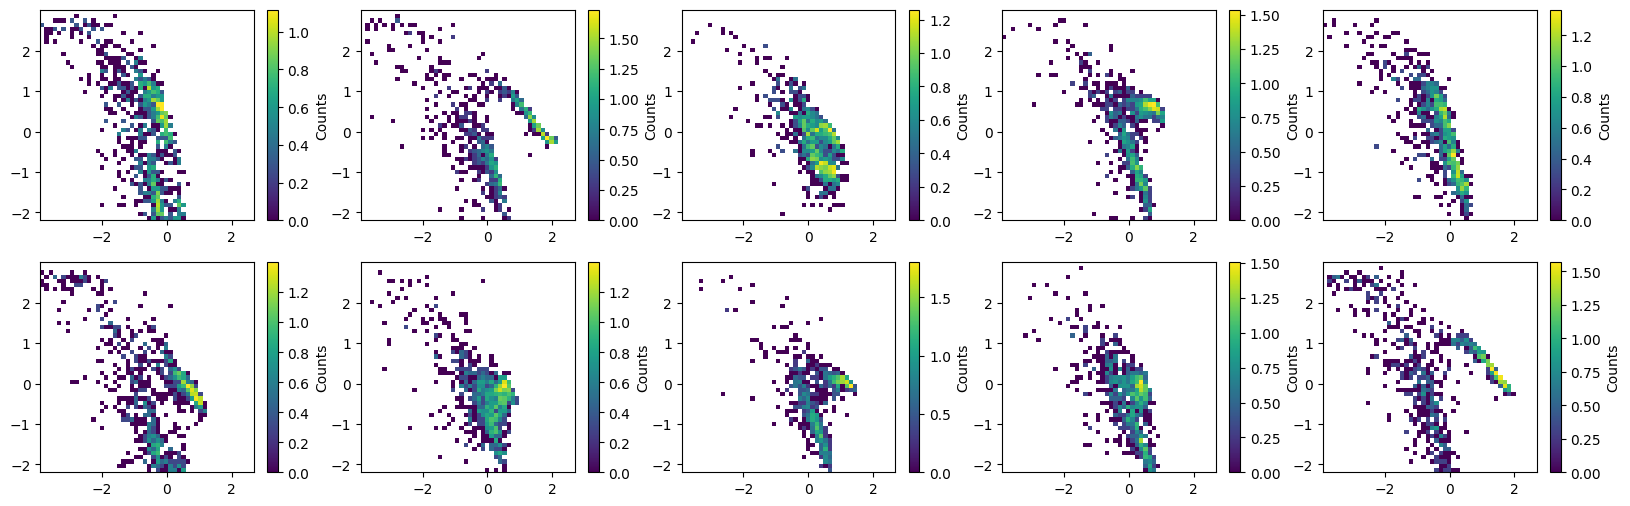

In [33]:
def simulator(theta, model, n_halos):
    with torch.no_grad():
        model.eval()
        batch_halos =  torch.zeros(theta.shape[0], 500*n_halos, 2)
        for n, batch in enumerate(theta):
            for i in range(n_halos):
                if i==0:
                    cond = batch[i::n_halos].repeat(500, 1)
                    halo = model.sample(500, cond=cond)
                else:
                    cond = batch[i::n_halos].repeat(500, 1)
                    halo = torch.vstack((halo, model.sample(500, cond=cond)))
            batch_halos[n] = halo
        return batch_halos

n_halos=2
batch = 10
for b in range(batch):
    data =  pd.read_parquet('../../data/dataframe/dataframe.parquet')
    data = data.drop(['feh', 'ofe', 'a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
    data = data[data['Galaxy_name'].isin(data['Galaxy_name'].sample(n_halos))].drop_duplicates()
    data =  data.drop(['Galaxy_name'],axis=1).values
    data = data.T.reshape(-1)
    if b == 0:
        theta =  data
    else:
        theta = np.vstack((theta, data))
        
theta = torch.from_numpy(theta).float().to(Flow.device)        
print(theta.shape)
# theta = torch.utils.data.DataLoader(torch.from_numpy(theta).float().to(Flow.device), batch_size=batch)
halos = simulator(theta, Flow, n_halos)
halos =  halos.cpu()
fig = plt.figure(figsize=(20, 6))
for i in range(batch):
    ax = fig.add_subplot(2, int(batch/2), i+1)
    # ax.scatter(halos[i, :, 0], halos[i, :, 1], s=2)
    hist, xedges, yedges = np.histogram2d(halos[i, :,0], halos[i, :,1], bins=50, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    # hist, xedges, yedges, im = ax.hist2d(x=fake_halo['feh'], y=fake_halo['ofe'], bins=50, cmap='magma');
    im = ax.imshow(np.log10(hist.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis')
    cbar = fig.colorbar(im, ax=ax, label='Counts')


In [13]:
class gen_halo_conditions(torch.distributions.Distribution):
    #THIS IS VERY SLOW
    def __init__(self, conditions:pd.DataFrame, n_bins:int=10, n_halos:int=10, return_numpy:bool=False):
        super().__init__()
        self.n_bins = n_bins
        self.mass_range = (min(conditions['star_log10mass']), max(conditions['star_log10mass']))
        self.bins = torch.linspace(self.mass_range[0], self.mass_range[1], self.n_bins)
        self.bin_indices =  torch.from_numpy(np.digitize(conditions['star_log10mass'], self.bins))
        self.conditions = conditions
        self.n_halos = n_halos
        self.return_numpy = return_numpy
        
    def torch_digitize(self, x, bins):
        bins = self.bins[:-1]
        idx = torch.searchsorted(bins, x)
        return idx    
    
    def sample(self, sample_shape):
        infall_time = torch.distributions.Uniform(low=min(self.conditions['infall_time']), high=max(self.conditions['infall_time'])).sample(torch.tensor([sample_shape[0], self.n_halos]))
        star_mass, _ = torch.sort(torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).sample(torch.tensor([sample_shape[0], self.n_halos])), descending=True)
        idx = self.torch_digitize(star_mass, self.bins)
        gas_mass =  torch.zeros_like(star_mass)
        dm_mass = torch.zeros_like(star_mass)
        mean_metallicity = torch.zeros_like(star_mass)
        std_metallicity = torch.zeros_like(star_mass)
        for n_i, i in enumerate(range(idx.shape[0])):
            for n_j, j in enumerate(range(idx.shape[1])):
                mean_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx[i, j]].mean() 
                std_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx[i, j]].std()
                gas_mass[i, j] = torch.distributions.Normal(loc=mean_gas, scale=std_gas).sample()
                
                mean_dm = torch.from_numpy(self.conditions['dm_log10mass'].values)[self.bin_indices == idx[i, j]].mean()
                std_dm = torch.from_numpy(self.conditions['dm_log10mass'].values)[self.bin_indices == idx[i, j]].std()
                dm_mass[i, j] = torch.distributions.Normal(loc=mean_dm, scale=std_dm).sample()
                
                mean_mean_metallicity = torch.from_numpy(self.conditions['mean_metallicity'].values)[self.bin_indices == idx[i, j]].mean()
                std_mean_metallicity = torch.from_numpy(self.conditions['mean_metallicity'].values)[self.bin_indices == idx[i, j]].std()
                mean_metallicity[i, j] = torch.distributions.Normal(loc=mean_mean_metallicity, scale=std_mean_metallicity).sample()
                
                mean_std_metallicity = torch.from_numpy(self.conditions['std_metallicity'].values)[self.bin_indices == idx[i, j]].mean()
                std_std_metallicity = torch.from_numpy(self.conditions['std_metallicity'].values)[self.bin_indices == idx[i, j]].std()
                std_metallicity[i, j] = torch.distributions.Normal(loc=mean_std_metallicity, scale=std_std_metallicity).sample()
                
        if self.return_numpy:
            return torch.hstack((star_mass, gas_mass, dm_mass, mean_metallicity, std_metallicity, infall_time)).numpy()
        else:
            return torch.hstack((star_mass, gas_mass, dm_mass, mean_metallicity, std_metallicity, infall_time))
    ## Not yet implemented correctly missing selection of the single halo condition in the value tensor
    # def log_prob(self, value):
    #     star_mass = value[:, :self.n_halos]
    #     gas_mass = value[:, self.n_halos:]
    #     log_prob = torch.zeros(value.shape[0])
    #     for i in range(value.shape[0]):
    #         for j in range(self.n_halos):
    #             log_prob[i] += torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).log_prob(star_mass[i, j])
    #             idx = self.torch_digitize(star_mass[i, j], self.bins)
    #             mean_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx].mean()
    #             std_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx].std()
    #             log_prob[i] += torch.distributions.Normal(loc=mean_gas, scale=std_gas).log_prob(gas_mass[i, j])
    #             mean_dm = torch.from_numpy(self.conditions['dm_log10mass'].values)[self.bin_indices == idx].mean()
    #             std_dm = torch.from_numpy(self.conditions['dm_log10mass'].values)[self.bin_indices == idx].std()
    #             log_prob[i] += torch.distributions.Normal(loc=mean_dm, scale=std_dm).log_prob(dm_mass[i, j])
    #             mean_mean_metallicity = torch.from_numpy(self.conditions['mean_metallicity'].values)[self.bin_indices == idx].mean()
    #             std_mean_metallicity = torch.from_numpy(self.conditions['mean_metallicity'].values)[self.bin_indices == idx].std()
    #             log_prob[i] += torch.distributions.Normal(loc=mean_mean_metallicity, scale=std_mean_metallicity).log_prob(mean_metallicity[i, j])
    #             mean_std_metallicity = torch.from_numpy(self.conditions['std_metallicity'].values)[self.bin_indices == idx].mean()
    #             std_std_metallicity = torch.from_numpy(self.conditions['std_metallicity'].values)[self.bin_indices == idx].std()
    #             log_prob[i] += torch.distributions.Normal(loc=mean_std_metallicity, scale=std_std_metallicity).log_prob(std_metallicity[i, j])
                
    #     if self.return_numpy:
    #         return log_prob.numpy()
    #     else:
    #         return log_prob        
    

In [23]:
class gen_halo_conditions_numpy():
    def __init__(self, conditions:pd.DataFrame, n_bins:int=10, n_halos:int=10):
        super().__init__()
        self.n_bins = n_bins
        self.mass_range = (min(conditions['star_log10mass']), max(conditions['star_log10mass']))
        self.bins = np.linspace(self.mass_range[0], self.mass_range[1], self.n_bins)
        self.bin_indices =  np.digitize(conditions['star_log10mass'], self.bins)
        self.conditions = conditions
        self.n_halos = n_halos
        
    def np_digitize(self, x, bins):
        bins = self.bins[:-1]
        idx = np.searchsorted(bins, x)
        return idx    
    
    def sample(self, sample_shape):
        infall_time = np.random.uniform(low=min(self.conditions['infall_time']), high=max(self.conditions['infall_time']), size=[sample_shape[0], self.n_halos])
        star_mass = np.sort(np.random.uniform(low=self.mass_range[0], high=self.mass_range[1], size=[sample_shape[0], self.n_halos]))[:, ::-1]
        idx = self.np_digitize(star_mass, self.bins)
        gas_mass =  np.zeros_like(star_mass)
        dm_mass = np.zeros_like(star_mass)
        mean_metallicity = np.zeros_like(star_mass)
        std_metallicity = np.zeros_like(star_mass)
        for n_i, i in enumerate(range(idx.shape[0])):
            for n_j, j in enumerate(range(idx.shape[1])):
                mean_gas = self.conditions['gas_log10mass'].values[self.bin_indices == idx[i, j]].mean() 
                std_gas = self.conditions['gas_log10mass'].values[self.bin_indices == idx[i, j]].std()
                gas_mass[i, j] = np.random.normal(loc=mean_gas, scale=std_gas, )
                
                mean_dm = self.conditions['dm_log10mass'].values[self.bin_indices == idx[i, j]].mean()
                std_dm = self.conditions['dm_log10mass'].values[self.bin_indices == idx[i, j]].std()
                dm_mass[i, j] = np.random.normal(loc=mean_dm, scale=std_dm, )
                
                mean_mean_metallicity = self.conditions['mean_metallicity'].values[self.bin_indices == idx[i, j]].mean()
                std_mean_metallicity = self.conditions['mean_metallicity'].values[self.bin_indices == idx[i, j]].std()
                mean_metallicity[i, j] = np.random.normal(loc=mean_mean_metallicity, scale=std_mean_metallicity,)
                
                mean_std_metallicity = self.conditions['std_metallicity'].values[self.bin_indices == idx[i, j]].mean()
                std_std_metallicity = self.conditions['std_metallicity'].values[self.bin_indices == idx[i, j]].std()
                std_metallicity[i, j] = np.random.normal(loc=mean_std_metallicity, scale=std_std_metallicity, )
        else:
            return np.hstack((star_mass, gas_mass, dm_mass, mean_metallicity, std_metallicity, infall_time))

/tmp/ipykernel_420262/2521333700.py:18: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(hist.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis')


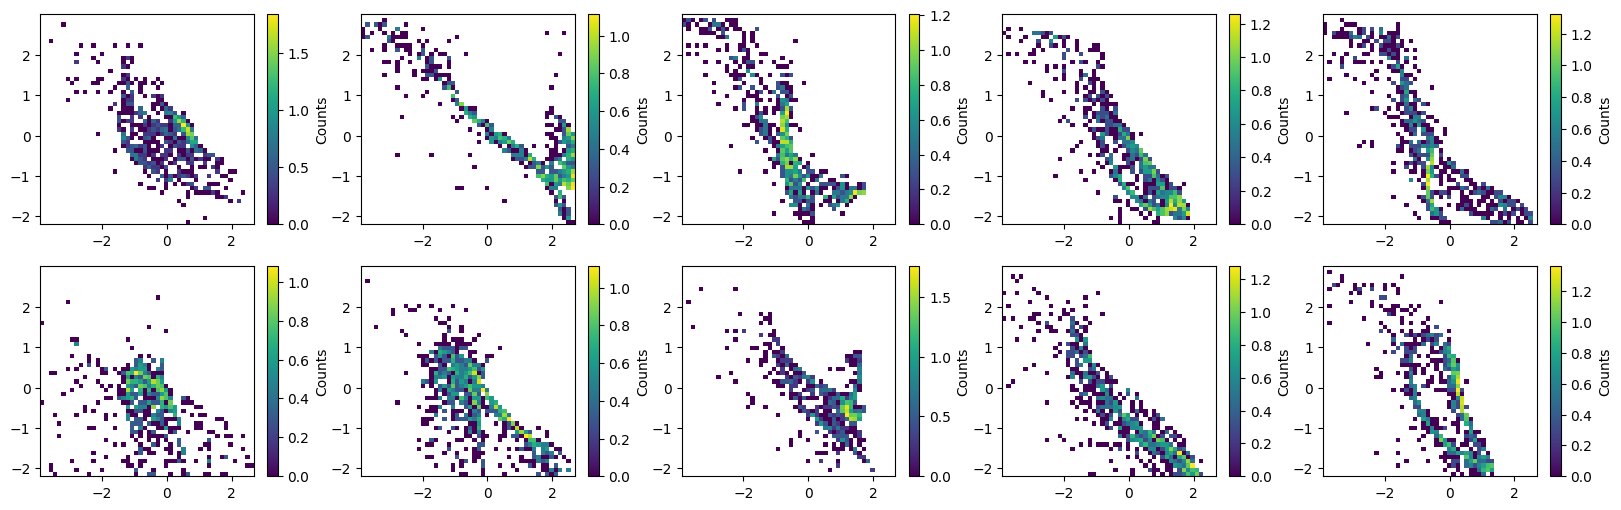

In [32]:
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
data =  data.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]
prior = gen_halo_conditions_numpy(conditions=conditions, n_bins=10, n_halos=2, )

sample_prior = prior.sample((10, ))
sample_prior = torch.from_numpy(sample_prior).float().to(Flow.device)
halos = simulator(sample_prior, Flow, n_halos=int(sample_prior.shape[1]/6))
halos = halos.cpu()
fig = plt.figure(figsize=(20, 6))
for i in range(halos.shape[0]):
    ax = fig.add_subplot(2, int(halos.shape[0]/2), i+1)
    # ax.scatter(halos[i, :, 0], halos[i, :, 1], s=2)
    hist, xedges, yedges = np.histogram2d(halos[i, :,0], halos[i, :,1], bins=50, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    # hist, xedges, yedges, im = ax.hist2d(x=fake_halo['feh'], y=fake_halo['ofe'], bins=50, cmap='magma');
    im = ax.imshow(np.log10(hist.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis')
    cbar = fig.colorbar(im, ax=ax, label='Counts')

/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Training neural network. Epochs trained: 1Training neural network. Epochs trained: 2Training neural network. Epochs trained: 3Training neural network. Epochs trained: 4Training neural network. Epochs trained: 5Training neural network. Epochs trained: 6Training neural network. Epochs trained: 7Training neural network. Epochs trained: 8Training neural network. Epochs trained: 9Training neural network. Epochs trained: 10Training neural network. Epochs trained: 11Training neural network. Epochs trained: 12Training neural network. Epochs trained: 13Training neural network. Epochs trained: 14Training neural network. Epochs trained: 15Training neural network. Epochs trained: 16Training neural network. Epochs trained: 17Training neural network. Epochs trained: 18Training neural network. Epochs trained: 19Training neural network. Epochs trained: 20Training neural network. Epochs trained: 21Training neural network. Epochs trained: 22Training neural network. Epochs trained: 23Training neural net

/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/sbiutils.py:617: UserWarning: The passed prior has no support property, transform will be
                constructed from mean and std. If the passed prior is supposed to be
                bounded consider implementing the prior.support property.
  warnings.warn(
/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/sbiutils.py:651: UserWarning: The passed prior has no mean or stddev attribute, estimating
                    them from samples to build affimed standardizing transform.
  warnings.warn(


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

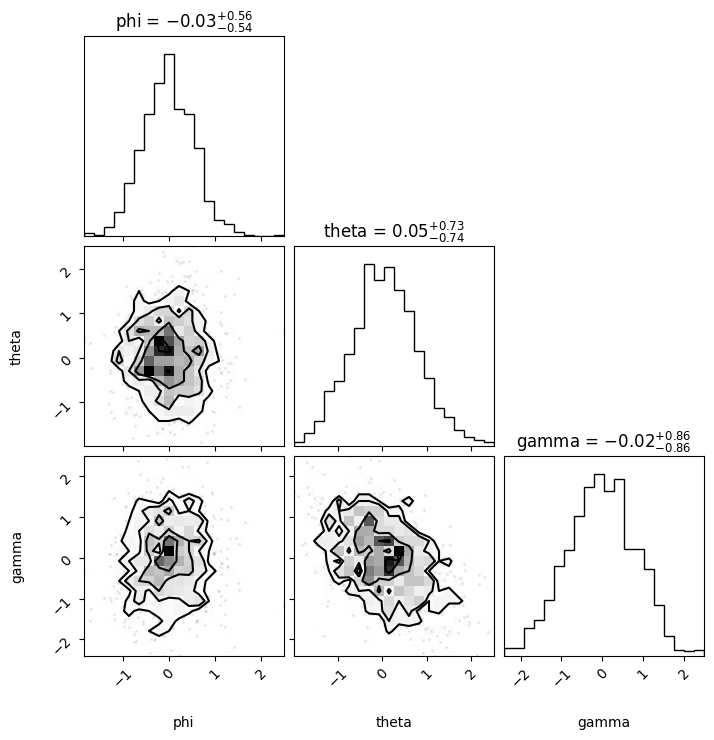

In [45]:
import torch
from torch.distributions import Distribution, Normal, Gamma, Poisson
from sbi.utils.get_nn_models import posterior_nn
from sbi.inference import SNPE, prepare_for_sbi
import corner
import matplotlib.pyplot as plt

class HierarchicalPrior(Distribution):
    def __init__(self, device='cpu'):
        super().__init__()
        self.phi_prior = Normal(torch.tensor(0., device=device), torch.tensor(1., device=device))
        self.device = device
        
    def sample(self, sample_shape=torch.Size([])):
        # Sample phi from its prior
        phi = self.phi_prior.sample(sample_shape).to(self.device)
        
        # Sample theta given phi
        theta = Normal(phi, torch.tensor(1., device=self.device)).sample()
        gamma = Normal(phi, torch.tensor(1., device=self.device)).sample()
        
        return torch.stack([phi, theta, gamma], dim=-1)
    
    def log_prob(self, value):
        # The first element is phi, the second is theta
        phi, theta, gamma = value[:, 0], value[:, 1], value[:, 2]
        
        # Compute the log probability of phi
        log_prob_phi = self.phi_prior.log_prob(phi)
        
        # Compute the log probability of theta given phi
        log_prob_theta_given_phi = Normal(phi, torch.tensor(1., device=self.device)).log_prob(theta)
        log_prob_gamma_given_phi = Normal(phi, torch.tensor(1., device=self.device)).log_prob(gamma)
        # Return the sum of log probabilities
        return log_prob_phi + log_prob_theta_given_phi + log_prob_gamma_given_phi

# Define the simulator function
def simulator(parameters):
    return parameters.sum(dim=-1, keepdim=True) + torch.randn(parameters.shape[0], 1, device=parameters.device)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the hierarchical prior
hierarchical_prior = HierarchicalPrior(device=device)

# Create the posterior using SNPE with the hierarchical prior
inference = SNPE(prior=hierarchical_prior, device='cuda')

# Prepare the simulator and the prior for inference
simulator, prior = prepare_for_sbi(simulator, hierarchical_prior)

# Generate training data
num_simulations = 1000
parameters = prior.sample((num_simulations,))
sim_data = simulator(parameters)

# Move the data to the GPU
parameters = parameters.to(device)
sim_data = sim_data.to(device)

# Conduct inference
inference.append_simulations(parameters, sim_data)
density_estimator = inference.train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

# Set a default context (e.g., some observation x)
default_x = torch.zeros(1, 1, device=device)
posterior.set_default_x(default_x)

# Sample from the posterior
samples = posterior.sample((1000,))

# Convert samples to CPU and numpy array for plotting
samples = samples.cpu().detach().numpy()

# Plot the posterior using a corner plot
corner.corner(samples, labels=["phi", "theta", "gamma"], show_titles=True)
plt.show()


 Training neural network. Epochs trained: 1Training neural network. Epochs trained: 2Training neural network. Epochs trained: 3Training neural network. Epochs trained: 4Training neural network. Epochs trained: 5Training neural network. Epochs trained: 6Training neural network. Epochs trained: 7Training neural network. Epochs trained: 8Training neural network. Epochs trained: 9Training neural network. Epochs trained: 10Training neural network. Epochs trained: 11Training neural network. Epochs trained: 12Training neural network. Epochs trained: 13Training neural network. Epochs trained: 14Training neural network. Epochs trained: 15Training neural network. Epochs trained: 16Training neural network. Epochs trained: 17Training neural network. Epochs trained: 18Training neural network. Epochs trained: 19Training neural network. Epochs trained: 20Training neural network. Epochs trained: 21Training neural network. Epochs trained: 22Training neural network. Epochs trained: 23Training neural net

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

(<Figure size 1000x1000 with 36 Axes>,
 array([[<Axes: xlabel='phi_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: xlabel='phi_2'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='theta_1'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='theta_2'>, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='gamma_1'>,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: xlabel='gamma_2'>]], dtype=object))

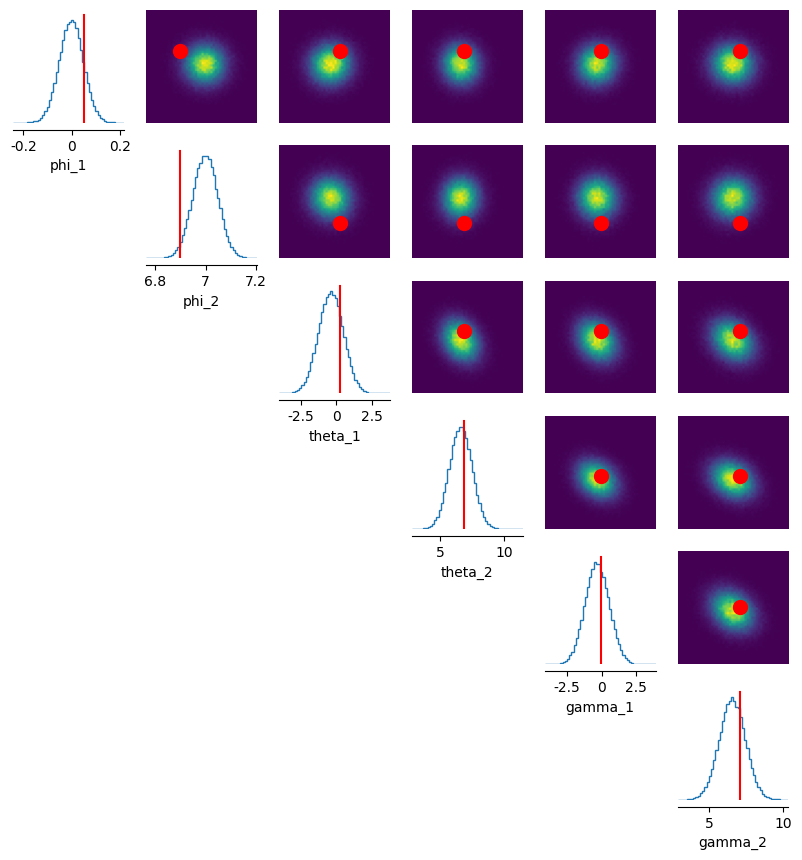

In [127]:
import torch
from torch.distributions import Distribution, Normal, Gamma, Poisson
from sbi.utils.get_nn_models import posterior_nn
from sbi.inference import SNPE, prepare_for_sbi
import corner
import matplotlib.pyplot as plt

class HierarchicalPrior(Distribution):
    def __init__(self, device='cpu'):
        super().__init__()
        self.phi_prior_1 = Normal(torch.tensor(0., device=device), torch.tensor(0.05, device=device))
        self.phi_prior_2 = Normal(torch.tensor(7., device=device), torch.tensor(0.05, device=device))
        self.device = device
        
    def sample(self, sample_shape=torch.Size([])):
        # Sample phi from its prior
        phi_1 = self.phi_prior_1.sample(sample_shape).to(self.device)
        
        # Sample theta given phi
        theta_1 = Normal(phi_1, torch.tensor(1., device=self.device)).sample()
        gamma_1 = Normal(phi_1, torch.tensor(1., device=self.device)).sample()
        
        
        # Sample phi from its prior
        phi_2 = self.phi_prior_2.sample(sample_shape).to(self.device)
        
        # Sample theta given phi
        theta_2 = Normal(phi_2, torch.tensor(1., device=self.device)).sample()
        gamma_2 = Normal(phi_2, torch.tensor(1., device=self.device)).sample()
        
        return torch.stack([phi_1, phi_2, theta_1, theta_2, gamma_1,  gamma_2], dim=-1)
    
    def log_prob(self, value):
        # The first element is phi, the second is theta
        phi_1,phi_2, theta_1, theta_2, gamma_1, gamma_2 = value[:, 0], value[:, 1], value[:, 2], value[:, 3], value[:, 4], value[:, 5]
        
        # Compute the log probability of phi
        log_prob_phi_1 = self.phi_prior_1.log_prob(phi_1)
        
        # Compute the log probability of theta given phi
        log_prob_theta_1_given_phi_1 = Normal(phi_1, torch.tensor(1., device=self.device)).log_prob(theta_1)
        log_prob_gamma_1_given_phi_1 = Normal(phi_1, torch.tensor(1., device=self.device)).log_prob(gamma_1)
        
        
        log_prob_phi_2 = self.phi_prior_2.log_prob(phi_2)
        
        log_prob_theta_2_given_phi_2 = Normal(phi_2, torch.tensor(1., device=self.device)).log_prob(theta_2)
        log_prob_gamma_2_given_phi_2 = Normal(phi_2, torch.tensor(1., device=self.device)).log_prob(gamma_2)
        
        # Return the sum of log probabilities
        return log_prob_phi_1 + log_prob_theta_1_given_phi_1 + log_prob_gamma_1_given_phi_1 + log_prob_phi_2 + log_prob_theta_2_given_phi_2 + log_prob_gamma_2_given_phi_2

# Define the simulator function
def simulator(parameters):
    return parameters.sum(dim=-1, keepdim=True) + torch.randn(parameters.shape[0], 1, device=parameters.device)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the hierarchical prior
hierarchical_prior = HierarchicalPrior(device=device)

# Create the posterior using SNPE with the hierarchical prior
inference = SNPE(prior=hierarchical_prior, device='cuda')

# Prepare the simulator and the prior for inference
simulator, prior = prepare_for_sbi(simulator, hierarchical_prior)

# Generate training data
num_simulations = 50000
parameters = prior.sample((num_simulations,))
sim_data = simulator(parameters)

# Move the data to the GPU
parameters = parameters.to(device)
sim_data = sim_data.to(device)

# Conduct inference
inference.append_simulations(parameters, sim_data)
density_estimator = inference.train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

# Set a default context (e.g., some observation x)
ground_truth =  torch.tensor([[0.05, 6.9, 0.27, 6.89, -0.02, 7.1]], device=device)
default_x = simulator(ground_truth)
# default_x = torch.ones(1, 1, device=device)
posterior.set_default_x(default_x)

# Sample from the posterior
samples = posterior.sample((100000,))

# Convert samples to CPU and numpy array for plotting
samples = samples.cpu().detach().numpy()

ground_truth = ground_truth.cpu().detach().numpy()

# Plot the posterior using a corner plot
# corner.corner(samples, labels=["phi_1",  "phi_2", "theta_1", "theta_2","gamma_1", "gamma_2"], show_titles=True)
# plt.show()

from sbi.analysis import pairplot
# Plot the posterior using a pairplot
labels = ["phi_1",  "phi_2", "theta_1", "theta_2","gamma_1", "gamma_2"]
pairplot(samples, labels=labels, points=ground_truth,  points_colors=["red"])


## Let's put all togheter for n_halos=2

In [204]:
import torch
from torch.distributions import Distribution, Normal, Gamma, Poisson
from sbi.utils.get_nn_models import posterior_nn
from sbi.inference import SNPE, prepare_for_sbi
import corner
import matplotlib.pyplot as plt

data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
data =  data.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]

class HierarchicalPrior(Distribution):
    def __init__(self, conditions,n_bins=10, device='cpu'):
        super().__init__()
        self.n_bins = n_bins
        self.conditions = conditions
        self.infall_time_range = (min(self.conditions['infall_time']), max(self.conditions['infall_time']))
        self.mass_range = (min(self.conditions['star_log10mass']), max(self.conditions['star_log10mass']))
        self.bins = np.linspace(self.mass_range[0], self.mass_range[1], self.n_bins)
        self.bin_indices =  np.digitize(conditions['star_log10mass'], self.bins)
    
        self.device = device

    def np_digitize(self, x, bins):
        bins = self.bins[:-1]
        idx = np.searchsorted(bins, x)
        return idx 
    
    def torch_digitize(self, x, bins):
        bins = torch.from_numpy(self.bins[:-1]).to(device=self.device)
        idx = torch.searchsorted(bins, x)
        return idx  
        
    def sample(self, sample_shape=torch.Size([])):
        #first draw
        infall_time_1 = np.random.uniform(low=self.infall_time_range[0], high=self.infall_time_range[1], size=sample_shape)
        star_mass_1 = np.random.uniform(low=self.mass_range[0], high=self.mass_range[1], size=sample_shape)
        idx_1 = self.np_digitize(star_mass_1, self.bins)
        
        infall_time_2 = np.random.uniform(low=self.infall_time_range[0], high=self.infall_time_range[1], size=sample_shape)
        star_mass_2 = np.random.uniform(low=self.mass_range[0], high=self.mass_range[1], size=sample_shape)
        idx_2 = self.np_digitize(star_mass_2, self.bins)
        
        if isinstance(idx_1, np.int64):
            mean_gas_1 = self.conditions['gas_log10mass'].values[self.bin_indices == idx_1].mean() 
            std_gas_1 = self.conditions['gas_log10mass'].values[self.bin_indices == idx_1].std()
            gas_mass_1 = np.random.normal(loc=mean_gas_1, scale=std_gas_1, size=sample_shape) 
            mean_dm_1 = self.conditions['dm_log10mass'].values[self.bin_indices == idx_1].mean()
            std_dm_1 = self.conditions['dm_log10mass'].values[self.bin_indices == idx_1].std()
            dm_mass_1 = np.random.normal(loc=mean_dm_1, scale=std_dm_1, size=sample_shape)
            mean_mean_metallicity_1 = self.conditions['mean_metallicity'].values[self.bin_indices == idx_1].mean()
            std_mean_metallicity_1 = self.conditions['mean_metallicity'].values[self.bin_indices == idx_1].std()
            mean_metallicity_1 = np.random.normal(loc=mean_mean_metallicity_1, scale=std_mean_metallicity_1, size=sample_shape)
            mean_std_metallicity_1 = self.conditions['std_metallicity'].values[self.bin_indices == idx_1].mean()
            std_std_metallicity_1 = self.conditions['std_metallicity'].values[self.bin_indices == idx_1].std()
            std_metallicity_1 = np.random.normal(loc=mean_std_metallicity_1, scale=std_std_metallicity_1, size=sample_shape)
        else:
            mean_gas_1 = np.array([np.mean(self.conditions['gas_log10mass'].values[self.bin_indices == idx]) for idx in idx_1])
            std_gas_1 = np.array([np.std(self.conditions['gas_log10mass'].values[self.bin_indices == idx]) for idx in idx_1])
            gas_mass_1 = np.random.normal(loc=mean_gas_1, scale=std_gas_1, size=sample_shape)
            mean_dm_1 = np.array([np.mean(self.conditions['dm_log10mass'].values[self.bin_indices == idx]) for idx in idx_1])
            std_dm_1 = np.array([np.std(self.conditions['gas_log10mass'].values[self.bin_indices == idx]) for idx in idx_1])
            dm_mass_1 = np.random.normal(loc=mean_dm_1, scale=std_dm_1, size=sample_shape)
            mean_mean_metallicity_1 = np.array([np.mean(self.conditions['mean_metallicity'].values[self.bin_indices == idx]) for idx in idx_1])
            std_mean_metallicity_1 = np.array([np.std(self.conditions['mean_metallicity'].values[self.bin_indices == idx]) for idx in idx_1])
            mean_metallicity_1 = np.random.normal(loc=mean_mean_metallicity_1, scale=std_mean_metallicity_1, size=sample_shape)
            mean_std_metallicity_1 = np.array([np.mean(self.conditions['std_metallicity'].values[self.bin_indices == idx]) for idx in idx_1])
            std_std_metallicity_1 = np.array([np.std(self.conditions['std_metallicity'].values[self.bin_indices == idx]) for idx in idx_1])
            std_metallicity_1 = np.random.normal(loc=mean_std_metallicity_1, scale=std_std_metallicity_1, size=sample_shape)
            
        if isinstance(idx_2, np.int64):
            #second draw
            mean_gas_2 = self.conditions['gas_log10mass'].values[self.bin_indices == idx_2].mean()
            std_gas_2 = self.conditions['gas_log10mass'].values[self.bin_indices == idx_2].std()
            gas_mass_2 = np.random.normal(loc=mean_gas_2, scale=std_gas_2, size=sample_shape)
            mean_dm_2 = self.conditions['dm_log10mass'].values[self.bin_indices == idx_2].mean()
            std_dm_2 = self.conditions['dm_log10mass'].values[self.bin_indices == idx_2].std()
            dm_mass_2 = np.random.normal(loc=mean_dm_2, scale=std_dm_2, size=sample_shape)
            mean_mean_metallicity_2 = self.conditions['mean_metallicity'].values[self.bin_indices == idx_2].mean()
            std_mean_metallicity_2 = self.conditions['mean_metallicity'].values[self.bin_indices == idx_2].std()
            mean_metallicity_2 = np.random.normal(loc=mean_mean_metallicity_2, scale=std_mean_metallicity_2, size=sample_shape)
            mean_std_metallicity_2 = self.conditions['std_metallicity'].values[self.bin_indices == idx_2].mean()
            std_std_metallicity_2 = self.conditions['std_metallicity'].values[self.bin_indices == idx_2].std()
            std_metallicity_2 = np.random.normal(loc=mean_std_metallicity_2, scale=std_std_metallicity_2, size=sample_shape)
        else:
            mean_gas_2 = np.array([np.mean(self.conditions['gas_log10mass'].values[self.bin_indices == idx]) for idx in idx_2])
            std_gas_2 = np.array([np.std(self.conditions['gas_log10mass'].values[self.bin_indices == idx]) for idx in idx_2])
            gas_mass_2 = np.random.normal(loc=mean_gas_2, scale=std_gas_2, size=sample_shape)
            mean_dm_2 = np.array([np.mean(self.conditions['dm_log10mass'].values[self.bin_indices == idx]) for idx in idx_2])
            std_dm_2 = np.array([np.std(self.conditions['dm_log10mass'].values[self.bin_indices == idx]) for idx in idx_2])
            dm_mass_2 = np.random.normal(loc=mean_dm_2, scale=std_dm_2, size=sample_shape)
            mean_mean_metallicity_2 = np.array([np.mean(self.conditions['mean_metallicity'].values[self.bin_indices == idx]) for idx in idx_2])
            std_mean_metallicity_2 = np.array([np.std(self.conditions['mean_metallicity'].values[self.bin_indices == idx]) for idx in idx_2])
            mean_metallicity_2 = np.random.normal(loc=mean_mean_metallicity_2, scale=std_mean_metallicity_2, size=sample_shape)
            mean_std_metallicity_2 = np.array([np.mean(self.conditions['std_metallicity'].values[self.bin_indices == idx]) for idx in idx_2])
            std_std_metallicity_2 = np.array([np.std(self.conditions['std_metallicity'].values[self.bin_indices == idx]) for idx in idx_2])
            std_metallicity_2 = np.random.normal(loc=mean_std_metallicity_2, scale=std_std_metallicity_2, size=sample_shape)
        
        
        return torch.stack([torch.sort(torch.from_numpy(star_mass_1), descending=True)[0], torch.sort(torch.from_numpy(star_mass_2), descending=True)[0], 
                            torch.from_numpy(gas_mass_1), torch.from_numpy(gas_mass_2), 
                            torch.from_numpy(dm_mass_1), torch.from_numpy(dm_mass_2), 
                            torch.from_numpy(mean_metallicity_1), torch.from_numpy(mean_metallicity_2), 
                            torch.from_numpy(std_metallicity_1), torch.from_numpy(std_metallicity_2), 
                            torch.from_numpy(infall_time_1), torch.from_numpy(infall_time_2)], dim=-1).to(self.device)
    
    def log_prob(self, value):
        # The first element is phi, the second is theta
        star_mass_1, star_mass_2, gas_mass_1, gas_mass_2, dm_mass_1, dm_mass_2, mean_metallicity_1, mean_metallicity_2, std_metallicity_1, std_metallicity_2, infall_time_1, infall_time_2 = value[:, 0], value[:, 1], value[:, 2], value[:, 3], value[:, 4], value[:, 5], value[:, 6], value[:, 7], value[:, 8], value[:, 9], value[:, 10], value[:, 11]
        
        log_prob_star_mass_1 = torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).log_prob(star_mass_1).to('cuda')
        log_prob_star_mass_2 = torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).log_prob(star_mass_2).to('cuda')

        idx_1 = self.torch_digitize(star_mass_1,  torch.from_numpy(self.bins).to('cuda') )
        idx_2 = self.torch_digitize(star_mass_2, torch.from_numpy(self.bins).to('cuda') )
        
        mean_gas_1 = torch.from_numpy(self.conditions['gas_log10mass'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_1].mean()
        std_gas_1 = torch.from_numpy(self.conditions['gas_log10mass'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_1].std()
        log_prob_gas_mass_1 = torch.distributions.Normal(loc=mean_gas_1, scale=std_gas_1, ).log_prob(gas_mass_1)
        
        mean_dm_1 = torch.from_numpy(self.conditions['dm_log10mass'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_1].mean()
        std_dm_1 = torch.from_numpy(self.conditions['dm_log10mass'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_1].std()
        log_prob_dm_mass_1 = torch.distributions.Normal(loc=mean_dm_1, scale=std_dm_1,  ).log_prob(dm_mass_1)
        
        mean_mean_metallicity_1 = torch.from_numpy(self.conditions['mean_metallicity'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_1].mean()
        std_mean_metallicity_1 = torch.from_numpy(self.conditions['mean_metallicity'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_1].std()
        log_prob_mean_metallicity_1 = torch.distributions.Normal(loc=mean_mean_metallicity_1, scale=std_mean_metallicity_1,  ).log_prob(mean_metallicity_1)
        
        mean_std_metallicity_1 = torch.from_numpy(self.conditions['std_metallicity'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_1].mean()
        std_std_metallicity_1 = torch.from_numpy(self.conditions['std_metallicity'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_1].std()
        log_prob_std_metallicity_1 = torch.distributions.Normal(loc=mean_std_metallicity_1, scale=std_std_metallicity_1, ).log_prob(std_metallicity_1)
        
        mean_gas_2 = torch.from_numpy(self.conditions['gas_log10mass'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_2].mean()
        std_gas_2 = torch.from_numpy(self.conditions['gas_log10mass'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_2].std()
        log_prob_gas_mass_2 = torch.distributions.Normal(loc=mean_gas_2, scale=std_gas_2,  ).log_prob(gas_mass_2)
        
        mean_dm_2 = torch.from_numpy(self.conditions['dm_log10mass'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_2].mean()
        std_dm_2 = torch.from_numpy(self.conditions['dm_log10mass'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_2].std()
        log_prob_dm_mass_2 = torch.distributions.Normal(loc=mean_dm_2, scale=std_dm_2,  ).log_prob(dm_mass_2)
        
        mean_mean_metallicity_2 = torch.from_numpy(self.conditions['mean_metallicity'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_2].mean()
        std_mean_metallicity_2 = torch.from_numpy(self.conditions['mean_metallicity'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_2].std()
        log_prob_mean_metallicity_2 = torch.distributions.Normal(loc=mean_mean_metallicity_2, scale=std_mean_metallicity_2, ).log_prob(mean_metallicity_2)
        
        mean_std_metallicity_2 = torch.from_numpy(self.conditions['std_metallicity'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_2].mean()
        std_std_metallicity_2 = torch.from_numpy(self.conditions['std_metallicity'].values).to('cuda')[torch.from_numpy(self.bin_indices).to('cuda') == idx_2].std()
        log_prob_std_metallicity_2 = torch.distributions.Normal(loc=mean_std_metallicity_2, scale=std_std_metallicity_2, ).log_prob(std_metallicity_2)
        
        log_prob_infall_time_1 = torch.distributions.Uniform(low=self.infall_time_range[0], high=self.infall_time_range[1],  ).log_prob(infall_time_1).to('cuda')
        log_prob_infall_time_2 = torch.distributions.Uniform(low=self.infall_time_range[0], high=self.infall_time_range[1],  ).log_prob(infall_time_2).to('cuda')
        
        # Return the sum of log probabilities
        return log_prob_star_mass_1 + log_prob_star_mass_2 + log_prob_gas_mass_1 + log_prob_gas_mass_2 + log_prob_dm_mass_1 + log_prob_dm_mass_2 + log_prob_mean_metallicity_1 + log_prob_mean_metallicity_2 + log_prob_std_metallicity_1 + log_prob_std_metallicity_2 + log_prob_infall_time_1 + log_prob_infall_time_2


def simulator(theta, model=Flow, n_halos=2, min_feh=min_feh, max_feh=max_feh, min_ofe=min_ofe, max_ofe=max_ofe):
    with torch.no_grad():
        model.eval()
        if len(theta.shape) == 1:
            for i in range(n_halos):
                if i==0:
                    cond = theta[i::n_halos].repeat(500, 1)
                    halo = model.sample(500, cond=cond)
                else:
                    cond = theta[i::n_halos].repeat(500, 1)
                    halo = torch.vstack((halo, model.sample(500, cond=cond)))
            batch_halos = halo
        else:
            batch_halos = torch.zeros(theta.shape[0], 500*n_halos, 2)
            for n, batch in enumerate(theta):
                for i in range(n_halos):
                    if i==0:
                        cond = batch[i::n_halos].repeat(500, 1)
                        halo = model.sample(500, cond=cond)
                    else:
                        cond = batch[i::n_halos].repeat(500, 1)
                        halo = torch.vstack((halo, model.sample(500, cond=cond)))
                batch_halos[n] = halo         
        hist, xedges, yedges = np.histogram2d(halos[i, :,0], halos[i, :,1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
        return hist
        
        
# Set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create an instance of the hierarchical prior
hierarchical_prior = HierarchicalPrior(conditions=conditions, device=device)


# Prepare the simulator and the prior for inference
simulator, prior = prepare_for_sbi(simulator, hierarchical_prior)

# Generate training data
num_simulations = 100
parameters = prior.sample((num_simulations,))
sim_data = simulator(parameters)

# Move the data to the GPU
parameters = parameters.to(device)
sim_data = sim_data.to(device)

#embdeddin nets and flow
embedding_net=CNNEmbedding(input_shape=(64, 64), in_channels=1,)
neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

# Create the posterior using SNPE with the hierarchical prior
inference = SNPE(prior=hierarchical_prior, density_estimator=neural_posterior, device='cuda')

# Conduct inference
inference.append_simulations(parameters, sim_data)
density_estimator = inference.train()

# Build posterior
posterior = inference.build_posterior(density_estimator)




2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/export/home/vgiusepp/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


 Training neural network. Epochs trained: 1Training neural network. Epochs trained: 2Training neural network. Epochs trained: 3Training neural network. Epochs trained: 4Training neural network. Epochs trained: 5Training neural network. Epochs trained: 6Training neural network. Epochs trained: 7Training neural network. Epochs trained: 8Training neural network. Epochs trained: 9Training neural network. Epochs trained: 10Training neural network. Epochs trained: 11Training neural network. Epochs trained: 12Training neural network. Epochs trained: 13Training neural network. Epochs trained: 14Training neural network. Epochs trained: 15Training neural network. Epochs trained: 16Training neural network. Epochs trained: 17Training neural network. Epochs trained: 18Training neural network. Epochs trained: 19Training neural network. Epochs trained: 20Training neural network. Epochs trained: 21Training neural network. Epochs trained: 22Training neural network. Epochs trained: 23Training neural net

/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/sbiutils.py:617: UserWarning: The passed prior has no support property, transform will be
                constructed from mean and std. If the passed prior is supposed to be
                bounded consider implementing the prior.support property.
  warnings.warn(
/export/home/vgiusepp/.local/lib/python3.10/site-packages/sbi/utils/sbiutils.py:651: UserWarning: The passed prior has no mean or stddev attribute, estimating
                    them from samples to build affimed standardizing transform.
  warnings.warn(


In [209]:
# Set a default context (e.g., some observation x)
true_parameter =  prior.sample((1))
x_observed = simulator(true_parameter).cpu().detach().numpy()

1


AttributeError: 'builtin_function_or_method' object has no attribute 'numpy'

In [ ]:

# Set a default context (e.g., some observation x)
true_parameter =  prior.sample((1))
x_observed = simulator(true_parameter)
# default_x = torch.ones(1, 1, device=device)
posterior.set_default_x(default_x)

# Sample from the posterior
samples = posterior.sample((100000,))

# Convert samples to CPU and numpy array for plotting
samples = samples.cpu().detach().numpy()

ground_truth = ground_truth.cpu().detach().numpy()

# Plot the posterior using a corner plot
# corner.corner(samples, labels=["phi_1",  "phi_2", "theta_1", "theta_2","gamma_1", "gamma_2"], show_titles=True)
# plt.show()

from sbi.analysis import pairplot
# Plot the posterior using a pairplot
labels = ["phi_1",  "phi_2", "theta_1", "theta_2","gamma_1", "gamma_2"]
pairplot(samples, labels=labels, points=ground_truth,  points_colors=["red"])
